# Permutation Test Example

We give two examples of using permutation tests to test hypotheses.
Our first example is an exact permutation test, while our second example is a Monte Carlo permutation test.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

from mltools.resampling import PermutationTest

## Exact Permutation Test

This is a replication of Ronald Fisher's *lady tasting tea* esperiment ([Wikipedia](https://en.wikipedia.org/wiki/Lady_tasting_tea)).

This experiment involved Muriel Bristol, Ph.D., a British phycologist who claimed to be able to tell whether milk or tea was added first to a cup.
Ronald Fisher designed an experiment to test this claim.
He prepared 8 cups of tea, 4 with milk added first and 4 with tea added first, and he served them to Bristol in random order.
Bristol was informed of the experimental design and instructed to select the four cups prepared by a certain method (i.e., those in which milk was added first).
In particular, Bristol knew that there were 4 cups of each kind, but she did not know the order in which they were served to her.
Surprisingly, Bristol chose correctly for each cup.

Fisher's null hypothesis was that the Bristol had no ability to distinguish between the cups in which milk was added first and the cups in which tea was added first.
To test this null hypothesis, Fisher's test statistic was the number of successful selections.

In [2]:
# Let 0 = milk first, 1 = tea first

# Bristol's correct guesses about cups prepared by adding milk first
milk = [0, 0, 0, 0]

# Bristol's correct guesses about cups prepared by adding tea first
tea = [1, 1, 1, 1]

# Test statistic: number of correct guesses
def stat(m, t):
    return np.sum(np.equal(m, 0)) + np.sum(np.equal(t, 1))

To determine whether Bristol's success could be attributed to chance alone (instead of innate ability), Fisher considered all possible ways of re-arranging Bristol's choices.
This leads to the exact permutation test, implemented in the MLTools `resampling` module as the `PermutationTest` class.

In [3]:
%%time
pt = PermutationTest(milk, tea, stat=stat)

CPU times: user 738 ms, sys: 6.31 ms, total: 744 ms
Wall time: 743 ms


We can visualize the test by plotting a histogram of the test statistic computed on all the possible ways that Bristol could have guessed.

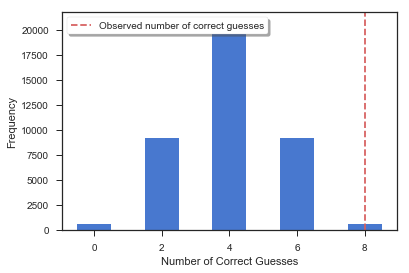

In [4]:
plt.figure()
plt.hist(pt.dist, bins=(np.arange(10) - 0.5))
plt.axvline(pt.observed, c="r", ls="--", label="Observed number of correct guesses")
plt.legend(loc="best", frameon=True, shadow=True)
plt.xlabel("Number of Correct Guesses")
plt.ylabel("Frequency")
plt.show()
plt.close()

Fisher computed a $p$-value from the test to quantify the probability that Bristol's correct guesses could be attributed to pure luck.

In [5]:
p_value = pt.p_value()
print(f"p-value: {p_value:.4f}")

p-value: 0.0143


This low $p$-value allows us to reject Fisher's null hypothesis at the $\alpha = 0.05$ significance level, suggesting that Muriel Bristol was unlikely to classify the cups correctly based on chance alone.

## Monte Carlo Permutation Test

This is a Python port (with modifications) of [Thomas Leeper's R permutation test example](http://thomasleeper.com/Rcourse/Tutorials/permutationtests.html).

We generate a sample $X$ of size $100$ from the $\mathrm{Bernoulli}(1/2)$ distribution and another sample $Y$ of size $150$ from the $\mathrm{Bernoulli}(1/2)$ offset by some $\mathrm{Normal}(1, 3^2)$ noise.

In [6]:
np.random.seed(0)
x = np.random.binomial(n=1, p=0.5, size=100)
y = np.random.binomial(n=1, p=0.5, size=150) + np.random.normal(loc=1, scale=3, size=150)

We visualize the observed samples $X$ and $Y$ using a histogram.

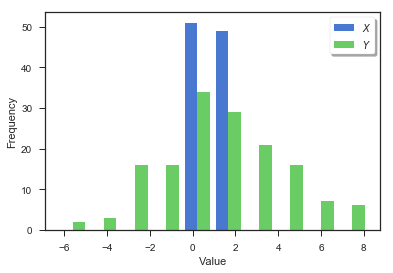

In [7]:
plt.figure()
plt.hist((x, y), label=("$X$", "$Y$"))
plt.legend(loc="best", frameon=True, shadow=True)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
plt.close()

Pretending we didn't know the distributions of $X$ and $Y$, we wish to test whether these data come from distributions with different means.
To test this hypothesis, our null hypothesis $H_0$ is that the underlying distributions *do* have the same mean.

A natural test statistic for this scenario is the absolute difference in means between two samples.
If $H_0$ were true, then this difference would be close to $0$.
If $H_0$ were false, then this difference would be significantly positive.

In [8]:
def stat(x, y):
    return np.abs(np.mean(x) - np.mean(y))

Since we know the true distributions of $X$ and $Y$, we expect the observed difference in means between $X$ and $Y$ to be close to $1$.

In [9]:
print(stat(x, y))

0.829291872847185


Now we perform a permutation test at the default $\alpha = 0.05$ significance level to determine whether this high of a difference could be attributed to chance alone (we expect it couldn't).

In [10]:
%%time
pt = PermutationTest(x, y, stat=stat, n_perm=15000, seed=0)

CPU times: user 609 ms, sys: 9 ms, total: 618 ms
Wall time: 616 ms


To visualize the test, we can plot the histogram of the empirical distribution of mean differences obtained for the permutated samples and compare it to the true mean difference.

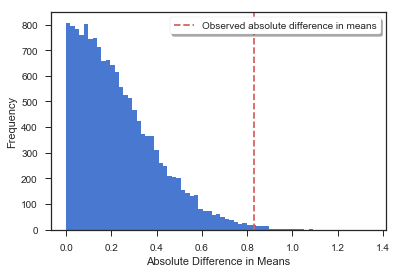

In [11]:
plt.figure()
plt.hist(pt.dist, bins="auto")
plt.axvline(pt.observed, c="r", ls="--", label="Observed absolute difference in means")
plt.legend(loc="best", frameon=True, shadow=True)
plt.xlabel("Absolute Difference in Means")
plt.ylabel("Frequency")
plt.show()
plt.close()

Having performed the test, we can now report a $p$-value.

In [12]:
p_value = pt.p_value(tail="right")
print(f"p-value: {p_value:.4f}")

p-value: 0.0057


This low $p$-value allows us to reject $H_0$ at the $\alpha = 0.05$ significance level, suggesting that the observed absolute difference in means is extreme relative to the empirical distribution of the mean differences of the permuted samples.